<ipython-input-2-3fee2f4ba276>:18: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df = df.resample('H').mean()
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - loss: 0.1658 - val_loss: 0.1121
Epoch 2/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0480 - val_loss: 0.0404
Epoch 3/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0336 - val_loss: 0.0385
Epoch 4/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0315 - val_loss: 0.0340
Epoch 5/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0269 - val_loss: 0.0310
Epoch 6/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0261 - val_loss: 0.0226
Epoch 7/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0186 - val_loss: 0.0521
Epoch 8/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0387 - val_loss: 0.0616
Epoch 9/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0307 - val_loss: 0.0258
Epoch 10/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0218 - val_loss: 0.0211
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


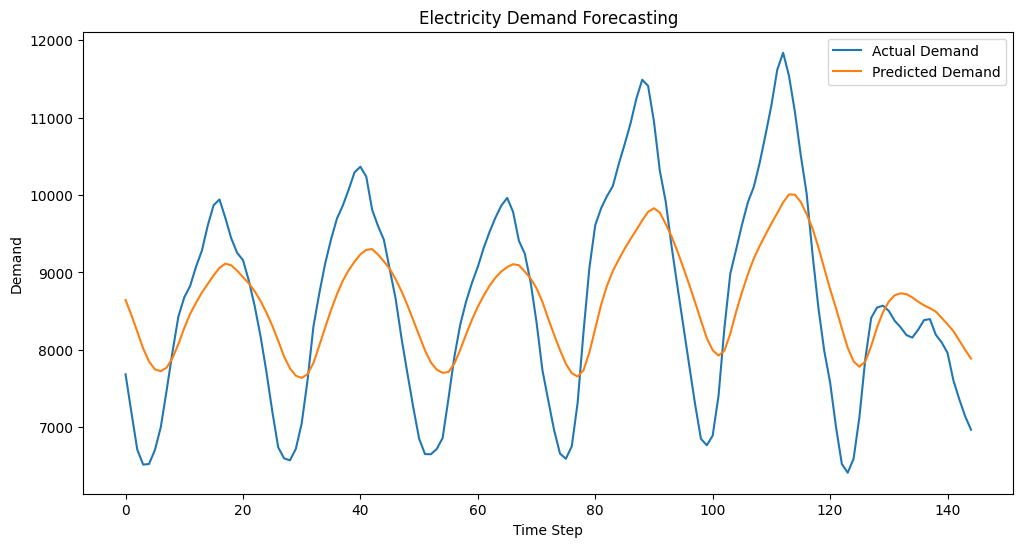

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Load and parse data
df = pd.read_csv('/content/PRICE_AND_DEMAND_201801_NSW1.csv')
df['SETTLEMENTDATE'] = pd.to_datetime(df['SETTLEMENTDATE'])
df.set_index('SETTLEMENTDATE', inplace=True)

# Select only numeric columns for resampling
numeric_columns = ['TOTALDEMAND']  # or include 'RRP' if you want to use price too
df = df[numeric_columns]

# Resample to hourly intervals and drop NaNs
df = df.resample('H').mean()
df.dropna(inplace=True)


# 2. Normalize the data
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(df[['TOTALDEMAND']])

# 3. Create sequences
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

SEQ_LENGTH = 24  # Use last 24 hours to predict the next hour
X, y = create_sequences(data_scaled, SEQ_LENGTH)

# 4. Train-test split
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# 5. Build the LSTM model
model = Sequential([
    LSTM(64, activation='relu', input_shape=(SEQ_LENGTH, 1)),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.1)

# 6. Evaluate and plot results
predictions = model.predict(X_test)
predicted_demand = scaler.inverse_transform(predictions)
actual_demand = scaler.inverse_transform(y_test)

plt.figure(figsize=(12, 6))
plt.plot(actual_demand, label='Actual Demand')
plt.plot(predicted_demand, label='Predicted Demand')
plt.legend()
plt.title("Electricity Demand Forecasting")
plt.xlabel("Time Step")
plt.ylabel("Demand")
plt.show()
